In [48]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import random
from scipy.interpolate import splprep, splev

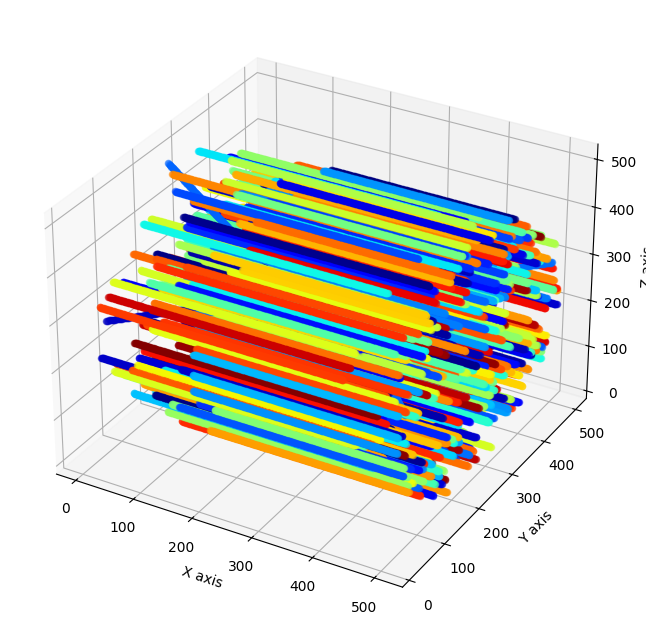

In [54]:
def initialize_pipe_volume(dimensions, pipe_radius):
    volume = np.ones(dimensions)  
    center_y, center_z = dimensions[1] // 2, dimensions[2] // 2  # x-axis!!

    for y in range(dimensions[1]):
        for z in range(dimensions[2]):
            if ((y - center_y)**2 + (z - center_z)**2) <= pipe_radius**2:
                volume[:, y, z] = 0  

    return volume

def is_within_bounds(point, volume, radius=1):
    x, y, z = point
    return radius <= x < volume.shape[0] - radius and radius <= y < volume.shape[1] - radius and radius <= z < volume.shape[2] - radius

def can_place_sphere(center, volume, radius=1):
    for x in range(-radius, radius + 1):
        for y in range(-radius, radius + 1):
            for z in range(-radius, radius + 1):
                if x**2 + y**2 + z**2 <= radius**2:
                    ix, iy, iz = center[0] + x, center[1] + y, center[2] + z
                    if not is_within_bounds((ix, iy, iz), volume, 0) or volume[ix, iy, iz] == 1:
                        return False
    return True

def add_voxel_sphere_to_volume(volume, center, radius=1):
    for x in range(-radius, radius + 1):
        for y in range(-radius, radius + 1):
            for z in range(-radius, radius + 1):
                if x**2 + y**2 + z**2 <= radius**2 and is_within_bounds((center[0]+x, center[1]+y, center[2]+z), volume, 0):
                    volume[center[0]+x, center[1]+y, center[2]+z] = 1

def update_volume_with_fiber(volume, fiber, radius=1):
    for point in fiber:
        add_voxel_sphere_to_volume(volume, point, radius)

def generate_and_count_fibers(volume, num_fibers, min_length=300, max_length=400, radius=3):
    successful_fibers = 0
    fibers = []
    total_attempts = 0
    max_total_attempts = 10000 
    
    while successful_fibers < num_fibers and total_attempts < max_total_attempts:
        fiber = generate_3d_fiber(volume, min_length, max_length, radius)
        if fiber is not None:
            update_volume_with_fiber(volume, fiber, radius)
            fibers.append(fiber)
            successful_fibers += 1
        total_attempts += 1

    if successful_fibers < num_fibers:
        print(f"Warning: Only able to place {successful_fibers} fibers after {total_attempts} attempts.")

    plot_fibers(volume, fibers, num_fibers)

    return successful_fibers, fibers

def plot_fibers(volume, fibers, num_fibers):
    colors = plt.cm.jet(np.linspace(0, 1, num_fibers))
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for idx, fiber in enumerate(fibers):
        plot_fiber(ax, fiber, color=colors[idx]) 
    
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")
    plt.show()

def plot_fiber(ax, fiber, color='b'):
    for point in fiber:
        x, y, z = point
        ax.scatter(x, y, z, color=color, alpha=0.5)

def generate_3d_fiber(volume, min_length=50, max_length=100, radius=1, 
                      curve_amplitude=0.0, curve_frequency=0.0, preferred_direction=[1, 0, 0], bias=0.90):
    attempts = 0
    max_attempts = 1000
    while attempts < max_attempts:
        center_point = np.array([random.randint(radius, dim - radius - 1) for dim in volume.shape])
        if can_place_sphere(center_point, volume, radius):
            break
        attempts += 1
    if attempts == max_attempts:
        return None

    fiber = [center_point]


    all_directions = [[1, 0, 0],
                      [1, 1, 0], [1, 0, 1], [0, 1, 1],
                      [-1, -1, 0],
                      [1, -1, 0], [1, 0, -1], [0, 1, -1],
                      [-1, 1, 0], [-1, 0, 1], [0, -1, 1]]
    all_directions = [np.array(d) for d in all_directions if d != preferred_direction]

    num_biased = int(bias * 100)
    num_other = 100 - num_biased
    num_other = min(num_other, len(all_directions)) 

    biased_direction_choices = [np.array(preferred_direction)] * num_biased
    
    biased_direction_choices.extend(random.sample(all_directions, k=num_other))

    direction = random.choice(biased_direction_choices).astype(float)

    # randomness, sinusoidal adjustment, predefined direction with bias

    step_size = 1 
    for step in range(max_length):
        curve = np.sin(step * curve_frequency) * curve_amplitude
        adjustment = np.array([curve if i == 0 else curve * random.uniform(-1, 1) for i in range(3)], dtype=float)
        direction += adjustment


        direction = direction / np.linalg.norm(direction)

        next_point = center_point + direction * step_size
        next_point_int = np.round(next_point).astype(int)

        if not is_within_bounds(next_point_int, volume, radius) or not can_place_sphere(next_point_int, volume, radius):
            if len(fiber) >= min_length:
                break
            else:
                return None

        fiber.append(next_point_int)
        center_point = next_point_int

    if len(fiber) < min_length:
        return None

    return fiber


volume_dimensions = [512, 512, 512]
volume = np.zeros(volume_dimensions)
pipe_radius = 250
volume = initialize_pipe_volume(volume_dimensions, pipe_radius)
num_fibers = 400

num_successful_fibers, fibers = generate_and_count_fibers(volume, num_fibers)



In [56]:
import nibabel as nib
import pydicom
import tifffile
from PIL import Image

def save_volume(volume, path, format):
    if format == '.npy':
        np.save(path, volume)
    elif format == '.nii': #for 3D slicer visualization
        nii_img = nib.Nifti1Image(volume.astype(np.int16), affine=np.eye(4))
        nib.save(nii_img, path)
    elif format == '.tiff':
        tifffile.imwrite(path, volume.astype(np.uint16))
    else:
        raise ValueError("Unsupported format")
   

save_volume(volume, 'aramid_fibers_400.nii', '.nii')
save_volume(volume, 'aramid_fibers_400.npy', '.npy')